In [10]:
from urllib import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt


# Load data

In [11]:
Data_T = pd.read_csv("ncaa_allstar_data_T.csv")
Data_F = pd.read_csv("ncaa_allstar_data_F.csv")
y_T = Data_T['allstar']
y_F = Data_F['allstar']
X_T = Data_T.drop(['PLAYER', 'TEAM', 'allstar'], axis = 1)
X_F = Data_T.drop(['PLAYER', 'TEAM', 'allstar'], axis = 1)


# Split data

In [12]:
def splitPermuteByNumber(X, y, cutoff):
    t_ind = X.index
    t_ind_perm = np.random.permutation(len(t_ind))
    perm = t_ind[t_ind_perm]

    ind = t_ind[t_ind_perm]
    t_ind_te = perm[:cutoff]
    t_ind_tr = perm[cutoff:]
    return X.loc[t_ind_te], X.loc[t_ind_tr], y.loc[t_ind_te], y.loc[t_ind_tr]

def splitPermuteByPercent(X, y, percent):
    cutoff = int(len(X) * percent)
    return splitPermuteByNumber(X, cutoff)

In [13]:
Xt_te, Xt_tr, yt_te, yt_tr = splitPermuteByNumber(X_T, y_T, 20)
Xf_te, Xf_tr, yf_te, yf_tr = splitPermuteByNumber(X_F, y_F, 20)
X_te = pd.concat([Xt_te, Xf_te])
X_tr = pd.concat([Xt_tr, Xf_tr])
y_te = pd.concat([yt_te, yf_te])
y_tr = pd.concat([yt_tr, yf_tr])

# Tools

In [14]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

def showROCCurve(y_te, y_pred):
    precision, recall, _ = precision_recall_curve(y_te, y_pred)
    average_precision = average_precision_score(y_te, y_pred)
    
    fpr, tpr, _ = roc_curve(y_te, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # plt.clf() will just clear the figure - you can still paint another plot onto it.
    lw = 2
    plt.clf()
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)    
    plt.plot(recall, precision, lw=lw, color='navy', label='Precision-Recall curve (AUC = %0.2f)' % average_precision)
    plt.xlabel('False Positive Rate(ROC)/Recall(PRC)')
    plt.ylabel('True Positive Rate(ROC)/Precision(PRC)')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="upper left")
    plt.show()

# Linear regression

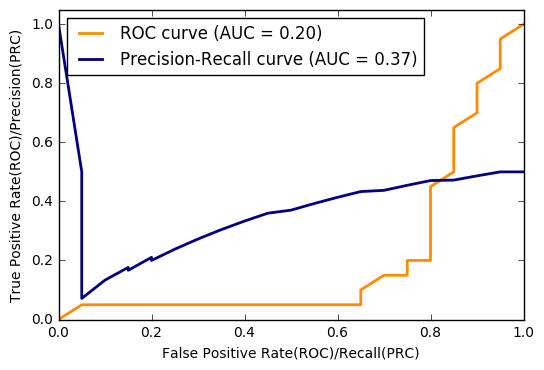

In [15]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_tr, y_tr)
y_pred = regr.predict(X_te)
showROCCurve(y_te, y_pred)

# Linear Discriminant Analysis

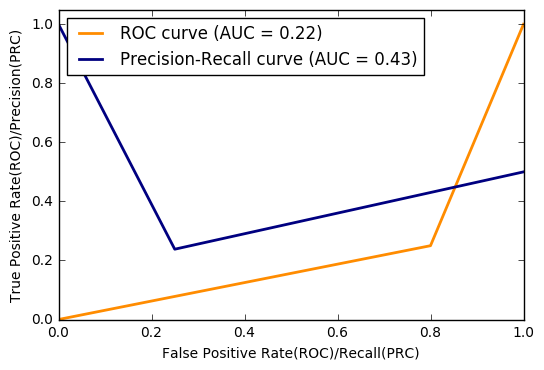

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred = lda.fit(X_tr, y_tr).predict(X_te)
showROCCurve(y_te, y_pred)

# QuadraticDiscriminantAnalysis

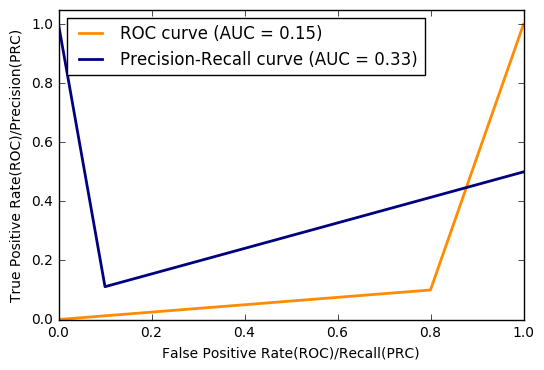

In [17]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis(store_covariances=True)
y_pred = qda.fit(X_tr, y_tr).predict(X_te)
showROCCurve(y_te, y_pred)

# Imbalanced-learn Pipeline


1.11.2
             precision    recall  f1-score   support

      False       0.45      0.70      0.55        20
       True       0.33      0.15      0.21        20

avg / total       0.39      0.42      0.38        40



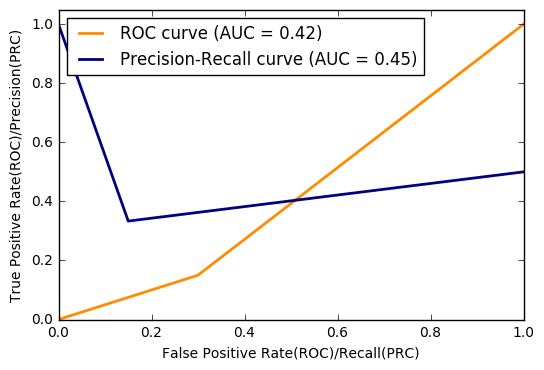

In [20]:
print np.version.version
from sklearn.cross_validation import train_test_split as tts
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier as KNN

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import (EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours)


# Create the samplers
enn = EditedNearestNeighbours()
renn = RepeatedEditedNearestNeighbours()
pca = PCA(n_components=2)

# Create teh classifier
knn = KNN(1)
#X_train, X_test, y_train, y_test = tts(X_tr, y_tr, random_state=42)


# Add one transformers and two samplers in the pipeline object
pipeline = make_pipeline(pca, enn, renn, knn)
pipeline.fit(X_tr, y_tr)
y_pred = pipeline.predict(X_te)

print(classification_report(y_te, y_pred))
showROCCurve(y_te, y_pred)